# Variational inference for a mixture density network model of a single-particle transition density

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import os
os.chdir("/home/s1511699/git/linf")
from tools.preprocessing import Scaler
tfd = tfp.distributions
tfpl = tfp.layers
tfkl = tf.keras.layers

In [2]:
import matplotlib.pyplot as plt
import cartopy
ccrs = cartopy.crs
import matplotlib.colors as colors
from cmocean import cm as cmo
import tools.grids as grids

In [71]:
plt.style.use('./misc/experiments.mplstyle')
model_dir = ("/home/s1511699/git/linf/dx_NA/models/0508_4dr/")

### Getting drifter data

In [4]:
BATCH_SIZE = 8192

data_dir = "/home/s1511699/git/linf/data/dx/"

X = np.load(data_dir + "X0_train.npy")
XVAL = np.load(data_dir + "X0_test.npy")
Y = np.load(data_dir + "DX_train.npy")
YVAL = np.load(data_dir + "DX_test.npy")

# Reorder data from (lat, lon) to (lon, lat) and deal with displacements
# which cross the dateline.
Xsets = [X, XVAL]
Ysets = [Y, YVAL]

for i, x in enumerate(Xsets):
    temp = x[:, 1].copy()
    x[:, 1] = x[:, 0]
    x[:, 0] = temp
    del temp, x

for i, y in enumerate(Ysets):
    temp = y[:, 1].copy()
    y[:, 1] = y[:, 0]
    y[:, 0] = temp
    del temp
    y[:, 0] += (y[:, 0] < -270.) * 360. + (y[:, 0] > 270.) * (-360.)

In [ ]:
print(X.shape, Y.shape)

In [ ]:
plt.figure()
plt.hist2d(X[::100, 0], X[::100, 1], bins=70, cmap='Reds')
plt.colorbar()
plt.show()

In [5]:
NAB = np.array([[-98.0539, 12.0059], [-0.936, 68.6387]])
IB = (X[:, 0] > NAB[0, 0]) * (X[:, 0] < NAB[0, 1]) * (X[:, 1] > NAB[1, 0]) * (X[:, 1] < NAB[1, 1])
X = X[IB, :]
Y = Y[IB, :]
IBV = (XVAL[:, 0] > NAB[0, 0]) * (XVAL[:, 0] < NAB[0, 1]) * (XVAL[:, 1] > NAB[1, 0]) * (XVAL[:, 1] < NAB[1, 1])
XVAL = XVAL[IBV, :]
YVAL = YVAL[IBV, :]

In [6]:
# Shuffle all data.
rng = np.random.default_rng(seed=1)
rng.shuffle(X)
rng = np.random.default_rng(seed=1)
rng.shuffle(XVAL)
rng = np.random.default_rng(seed=1)
rng.shuffle(Y)
rng = np.random.default_rng(seed=1)
rng.shuffle(YVAL)

# Truncate data to be divisible by batch_size / train_size.
N = int(min(X.shape[0], XVAL.shape[0]) // BATCH_SIZE) * BATCH_SIZE
X = X[:N, :]
XVAL = XVAL[:N, :]
Y = Y[:N, :]
YVAL = YVAL[:N, :]

# Standardise data.
Xscaler = Scaler(X)
X_ = Xscaler.standardise(X)
X_VAL = Xscaler.standardise(XVAL)
Yscaler = Scaler(Y)
Y_ = Yscaler.standardise(Y)
Y_VAL = Yscaler.standardise(YVAL)

In [ ]:
print(X.shape, Y.shape)

In [ ]:
plt.figure()
h, x, y, _ = plt.hist2d(X[:, 0], X[:, 1], bins=6)  # , cmap='Reds')
xx, yy = np.meshgrid(x, y)
plt.pcolormesh(xx, yy, h.T, shading='auto')
# plt.colorbar()
plt.show()

### Building probabilistic model

In [ ]:
def prior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  return lambda t: tfd.Independent(tfd.Normal(loc=tf.zeros(n, dtype=dtype), scale=1),  # !!!!!!!!!
          reinterpreted_batch_ndims=1)

In [ ]:
def posterior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
      tfpl.IndependentNormal(n)])

In [58]:
# del model
NC = 24

# from tensorflow_probability.python.distributions import kullback_leibler as kl_lib
kl_lib = tfd.kullback_leibler

# # 2dr
# model = tf.keras.Sequential([
#     # tfpl.DenseVariational(8, posterior, prior, kl_weight=1 / X.shape[0], kl_use_exact=True, activation='relu'),
#     tfkl.Dense(256, activation='relu'),
    # tfkl.Dense(256, activation='relu'),
    # tfkl.Dense(256, activation='relu'),
    # tfkl.Dense(256, activation='relu'),
#     tfkl.Dense(512, activation='relu'),
#     tfkl.Dense(512, activation='relu'),
#     # tfpl.DenseVariational(512, posterior, prior, kl_weight=1 / X.shape[0], kl_use_exact=True, activation='relu'),
#     tfpl.DenseReparameterization(512,
#                                 kernel_divergence_fn=(lambda q, p, ignore: kl_lib.kl_divergence(q, p) / X.shape[0]),
#                                 bias_divergence_fn=(lambda q, p, ignore: kl_lib.kl_divergence(q, p) / X.shape[0]),
#                                  activation='relu'),
#     tfpl.DenseReparameterization(6 * NC,
#                                 kernel_divergence_fn=(lambda q, p, ignore: kl_lib.kl_divergence(q, p) / X.shape[0]),
#                                 bias_divergence_fn=(lambda q, p, ignore: kl_lib.kl_divergence(q, p) / X.shape[0])),
#     tfpl.MixtureSameFamily(NC, tfp.layers.MultivariateNormalTriL(2))])

# 4dr
model = tf.keras.Sequential([
    tfpl.DenseReparameterization(256,
                                kernel_divergence_fn=(lambda q, p, ignore: kl_lib.kl_divergence(q, p) / X.shape[0]),
                                bias_divergence_fn=(lambda q, p, ignore: kl_lib.kl_divergence(q, p) / X.shape[0]),
                                 activation='relu'),
    tfkl.Dense(256, activation='relu'),
    tfkl.Dense(256, activation='relu'),
    tfkl.Dense(256, activation='relu'),
    tfpl.DenseReparameterization(512,
                                kernel_divergence_fn=(lambda q, p, ignore: kl_lib.kl_divergence(q, p) / X.shape[0]),
                                bias_divergence_fn=(lambda q, p, ignore: kl_lib.kl_divergence(q, p) / X.shape[0]),
                                 activation='relu'),
    tfpl.DenseReparameterization(512,
                                kernel_divergence_fn=(lambda q, p, ignore: kl_lib.kl_divergence(q, p) / X.shape[0]),
                                bias_divergence_fn=(lambda q, p, ignore: kl_lib.kl_divergence(q, p) / X.shape[0]),
                                 activation='relu'),
    tfpl.DenseReparameterization(6 * NC,
                                kernel_divergence_fn=(lambda q, p, ignore: kl_lib.kl_divergence(q, p) / X.shape[0]),
                                bias_divergence_fn=(lambda q, p, ignore: kl_lib.kl_divergence(q, p) / X.shape[0])),
    tfpl.MixtureSameFamily(NC, tfp.layers.MultivariateNormalTriL(2))])

In [59]:
def negloglik(y, rv_y): return -rv_y.log_prob(y)
LOSS = negloglik
LEARNING_RATE = 5e-4
OPTIMISER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

EPOCHS = 20

model.compile(loss=LOSS, optimizer=OPTIMISER)

In [88]:
History = model.fit(X_, Y_, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_VAL, Y_VAL), verbose=1)

Epoch 1/20
287/287 [==============================] - 103s 360ms/step - loss: 2.5952 - val_loss: 2.6418
Epoch 2/20
287/287 [==============================] - 109s 382ms/step - loss: 2.5890 - val_loss: 2.6365
Epoch 3/20
287/287 [==============================] - 109s 379ms/step - loss: 2.5809 - val_loss: 2.6230
Epoch 4/20
287/287 [==============================] - 109s 379ms/step - loss: 2.5742 - val_loss: 2.6235
Epoch 5/20
287/287 [==============================] - 109s 379ms/step - loss: 2.5664 - val_loss: 2.6112
Epoch 6/20
287/287 [==============================] - 109s 380ms/step - loss: 2.5583 - val_loss: 2.6049
Epoch 7/20
287/287 [==============================] - 109s 381ms/step - loss: 2.5505 - val_loss: 2.6017
Epoch 8/20
287/287 [==============================] - 109s 379ms/step - loss: 2.5450 - val_loss: 2.5958
Epoch 9/20
287/287 [==============================] - 128s 447ms/step - loss: 2.5371 - val_loss: 2.5874
Epoch 10/20
287/287 [==============================] - 110s 384m

In [98]:
model.save_weights(model_dir + "second_training/weights")

In [ ]:
# model.load_weights("dx_NA/models/DV2/weights")

In [ ]:
model(X_[:BATCH_SIZE, ...])

In [ ]:
model.layers[-2].weights[2].numpy().std()

In [ ]:
model.summary()

### Results

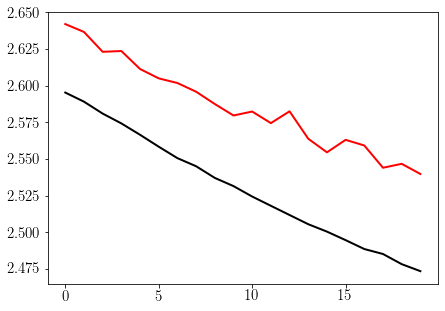

In [90]:
plt.figure()
plt.plot(History.history['loss'], 'k')
plt.plot(History.history['val_loss'], 'r')
plt.savefig(model_dir + "loss2.png", dpi=144)
plt.show()

In [91]:
res = 4.  # Grid points per degree
grid = grids.LonlatGrid(xlims=NAB[0], ylims=NAB[1], n_x=110 * res, n_y=70 * res)

means = []
covs = []
for i in range(10):
    gms_ = grid.eval_on_grid(model, scaler=Xscaler.standardise)
    means.append(Yscaler.invert_standardisation_loc(gms_.mean())[None, ...])
    covs.append(Yscaler.invert_standardisation_cov(gms_.covariance())[None, ...])

In [92]:
means = tf.concat(means, axis=0)
covs = tf.concat(covs, axis=0)

In [93]:
mean_of_mean = tf.math.reduce_mean(means, axis=0).numpy().reshape(
                grid.centres.shape[:-1] + (2,))[..., 0]
mean_of_cov = tf.math.reduce_mean(covs, axis=0).numpy().reshape(
                grid.centres.shape[:-1] + (2, 2))[..., 0, 0]
std_of_mean = tf.math.reduce_std(means, axis=0).numpy().reshape(
                grid.centres.shape[:-1] + (2,))[..., 0]
std_of_cov = tf.math.reduce_std(covs, axis=0).numpy().reshape(
                grid.centres.shape[:-1] + (2, 2))[..., 0, 0]

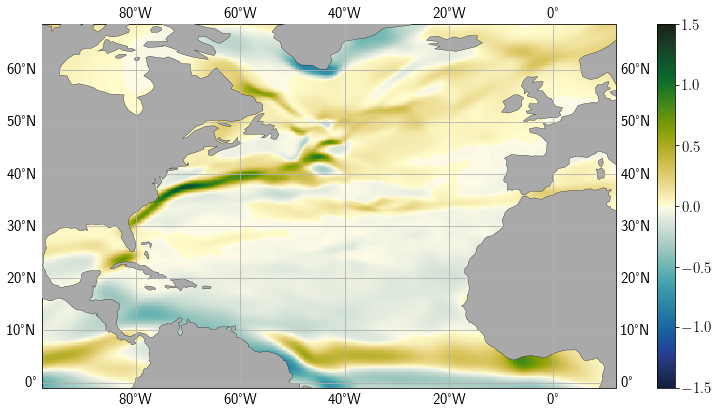

In [100]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, dms=True,
             x_inline=False, y_inline=False, zorder=11)
sca = plt.pcolormesh(grid.vertices[..., 0], grid.vertices[..., 1],
                     mean_of_mean,
                     cmap=cmo.delta,
                     shading='flat',
                     norm=colors.CenteredNorm(halfrange=1.5),
                     transform=ccrs.PlateCarree())
plt.colorbar(sca)
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k',
               facecolor='darkgrey',
               linewidth=0.3)
plt.tight_layout()
# plt.savefig(model_dir + "mean_mDX.png", dpi=288)
plt.show()

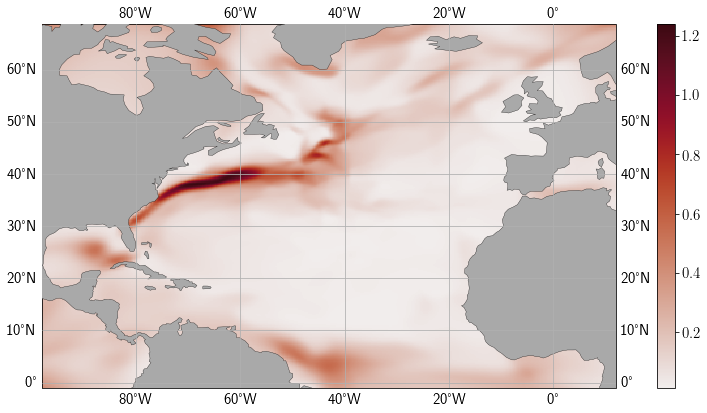

In [95]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, dms=True,
             x_inline=False, y_inline=False, zorder=11)
sca = plt.pcolormesh(grid.vertices[..., 0], grid.vertices[..., 1],
                     mean_of_cov,
                     cmap=cmo.amp,
                     shading='flat',
                     transform=ccrs.PlateCarree())
plt.colorbar(sca)
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k',
               facecolor='darkgrey',
               linewidth=0.3)
plt.tight_layout()
# plt.savefig(model_dir + "mean_covDX.png", dpi=288)
plt.show()

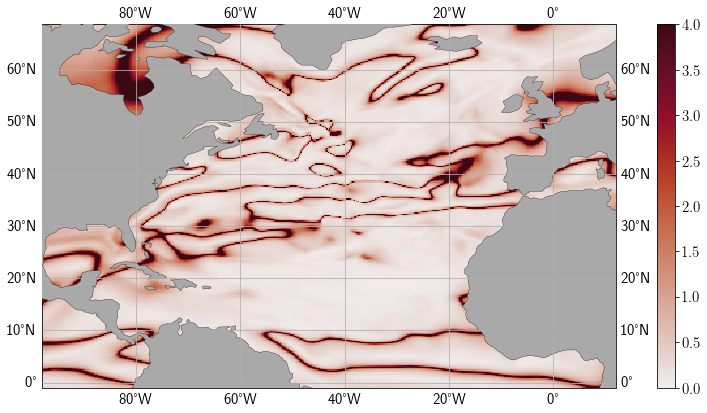

In [96]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, dms=True,
             x_inline=False, y_inline=False, zorder=11)
sca = plt.pcolormesh(grid.vertices[..., 0], grid.vertices[..., 1],
                     std_of_mean / np.abs(mean_of_mean),
                     cmap=cmo.amp, vmin=0., vmax=4.,
                     shading='flat',
                     transform=ccrs.PlateCarree())
plt.colorbar(sca)
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k',
               facecolor='darkgrey',
               linewidth=0.3)
plt.tight_layout()
# plt.savefig(model_dir + "std_mDX.png", dpi=288)
plt.show()

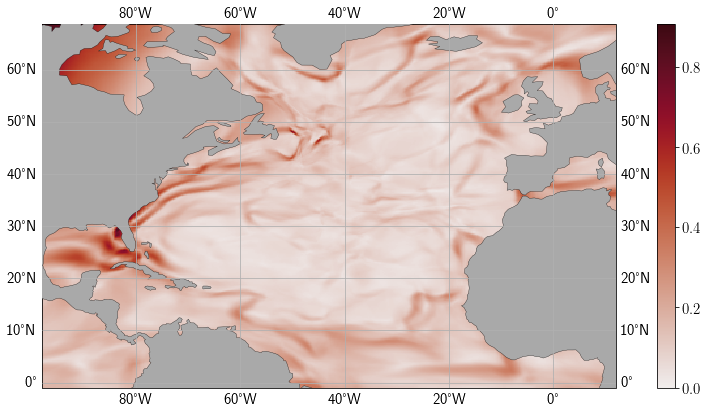

In [97]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, dms=True,
             x_inline=False, y_inline=False, zorder=11)
sca = plt.pcolormesh(grid.vertices[..., 0], grid.vertices[..., 1],
                     std_of_cov / mean_of_cov,
                     cmap=cmo.amp, vmin=0.,  # vmax=0.25,
                     shading='flat',
                     transform=ccrs.PlateCarree())
plt.colorbar(sca)
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k',
               facecolor='darkgrey',
               linewidth=0.3)
plt.tight_layout()
# plt.savefig(model_dir + "stdcovDX.png", dpi=288)
plt.show()